# Makemore from Scratch Part 2: MLP

In this notebook, I'm following along with the YouTube video [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3), where [Andrej Karpathy](https://www.youtube.com/@AndrejKarpathy) walks through building a language model from scratch.

In particular, we're going to implement a Multi-Layer Perceptron (MLP) model. The MLP model is described in [this paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

A MLP is a multi-layered neural network with an input layer, one or more hidden layers, and an output layer. 

In an NLP context, one way we can use this is to feed example sentences that are composed of a vocabulary of words (e.g. 17000 words) into a model that represents an `m`-dimensional feature space. We then optimize those word vectors based on our examples. This creates ***word embeddings*** where each word becomes a vector in this space. Words that have similar meanings or are synonyms will be close to one another, and words that don't have much to do with one another will be farther apart. 


An example, from the paper, of how it might work in more detail is to build a neural network that we feed in the three previous words and it gives us the next word. 

1. We get the input for each of the three previous words as an integer and then do a lookup in our vocabulary (17000 words) to get an index.
2. We then look up each word in a matrix C, which is of size (17000 x 30), and has all of our word embeddings
3. We then take the three 30-neuron vectors and use them as inputs into the input layer of our neural network, which is 90-neurons
4. We feed the input layer into a hidden layer, which can be any size (e.g. 100 neurons). The hidden layer will have a non-linear activation function like `tanh` or `ReLU` applied to it.
5. The hidden layer feeds in to a 17000-neuron output layer. These each are logits, which we then exponentiate and normalize to sum to 1 (i.e. softmax activation). This gives us the probability of our next word in the sequence, which we can look up from our vocabulary.

During training we know the next word, so we use that to train the model using back propagation.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }
print( itos )

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many chars do we take to predict the next one?

X, Y = [], [] # X=inputs, Y=labels
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Setting up a Word Embedding matrix

We'll start with a 2-dimensional space for our Word Embeddings

In [7]:
# Word Embeddings: ( vocab_size, feature_space_size )
C = torch.randn(( 27, 2 ))

Before we embed all the integers into the inputs X using the lookup table C, let's just try to embed a single input integer (e.g. `5`). 

We can do it in two ways, either by directly doing an index lookup from our Word Embeddings matrix C, or by using a one-hot encoding vector that we multiply with our matrix C.

In [8]:
C.shape

torch.Size([27, 2])

In [9]:
# One way is to just get row 5: C[5]
C[5]

tensor([-0.3299,  0.9989])

In [10]:
# Another way (which is identical)
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [11]:
# (1, 27) x (27, 2) -> (1, 2)
# The one-hot encoding effectively plucks out the 5th row from C
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.3299,  0.9989])

## Mapping examples to embeddings

Now let's play around with how we can do lookups from the matrix C using PyTorch.

In [12]:
C[5]

tensor([-0.3299,  0.9989])

In [13]:
C[[5, 6, 7]]

tensor([[-0.3299,  0.9989],
        [ 2.3768,  0.3461],
        [ 0.4453,  0.5977]])

In [14]:
C[torch.tensor([5,6,7,7,7,7])]

tensor([[-0.3299,  0.9989],
        [ 2.3768,  0.3461],
        [ 0.4453,  0.5977],
        [ 0.4453,  0.5977],
        [ 0.4453,  0.5977],
        [ 0.4453,  0.5977]])

In [15]:
C[torch.tensor([[5,6],[7,8]])]

tensor([[[-0.3299,  0.9989],
         [ 2.3768,  0.3461]],

        [[ 0.4453,  0.5977],
         [ 0.4187,  0.7211]]])

In [16]:
X[13]

tensor([0, 0, 1])

In [17]:
print(''.join(itos[i.item()] for i in X[13]))

..a


In [18]:
X[13,2]

tensor(1)

In [19]:
C[X][13,2]

tensor([-0.1024,  0.4119])

In [20]:
# So we can embed all of our integers in X simultaneously using C[X]
#   This is 32x3x2
#      32 - examples
#       3 - bucket_size
#       2 - dimensionality of our vector space for word embeddings
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [21]:
# This gives us the two dimensional word embeddings for each 
#   character in example X[13] (e.g. [0,0,1] which is the string '..a')
emb[13]

tensor([[-0.2606,  0.3364],
        [-0.2606,  0.3364],
        [-0.1024,  0.4119]])

In [22]:
[C[0], C[0], C[1]]

[tensor([-0.2606,  0.3364]),
 tensor([-0.2606,  0.3364]),
 tensor([-0.1024,  0.4119])]

## Hidden Layer

Now let's set up our hidden layer, which we'll call `W1`.

The inputs into the layer is 3x2 (three two-dimensional embeddings)

In [23]:
W1 = torch.randn((6, 100)) # 100-neuron hidden layer
b1 = torch.randn(100) # biases

In [24]:
# We want to do something like this, but we have to modify the dimensions first
# emb @ W1 + b1

# one method (which doesn't generalize using block_size)
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([32, 6])

In [25]:
# another method (using torch.unbind)
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [26]:
# yet another (better) way is to use tensor.view
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [27]:
a.shape

torch.Size([18])

In [28]:
# view is extremely efficient
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [29]:
# how the tensor is stored under the covers
a.storage()

/var/folders/15/6rgmnctj23qfg645kbwvjwdm0000gp/T/ipykernel_43878/317272418.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [30]:
emb.view(32,6)

tensor([[-0.2606,  0.3364, -0.2606,  0.3364, -0.2606,  0.3364],
        [-0.2606,  0.3364, -0.2606,  0.3364, -0.3299,  0.9989],
        [-0.2606,  0.3364, -0.3299,  0.9989,  0.9781,  0.3163],
        [-0.3299,  0.9989,  0.9781,  0.3163,  0.9781,  0.3163],
        [ 0.9781,  0.3163,  0.9781,  0.3163, -0.1024,  0.4119],
        [-0.2606,  0.3364, -0.2606,  0.3364, -0.2606,  0.3364],
        [-0.2606,  0.3364, -0.2606,  0.3364, -2.3935, -0.8826],
        [-0.2606,  0.3364, -2.3935, -0.8826,  0.6515, -0.4445],
        [-2.3935, -0.8826,  0.6515, -0.4445, -0.1312, -0.0844],
        [ 0.6515, -0.4445, -0.1312, -0.0844, -0.2118, -0.4452],
        [-0.1312, -0.0844, -0.2118, -0.4452, -0.1312, -0.0844],
        [-0.2118, -0.4452, -0.1312, -0.0844, -0.1024,  0.4119],
        [-0.2606,  0.3364, -0.2606,  0.3364, -0.2606,  0.3364],
        [-0.2606,  0.3364, -0.2606,  0.3364, -0.1024,  0.4119],
        [-0.2606,  0.3364, -0.1024,  0.4119, -0.2118, -0.4452],
        [-0.1024,  0.4119, -0.2118, -0.4

In [31]:
# Now we can do
emb.view(32,6) @ W1 + b1

tensor([[-1.8115, -1.1085, -0.2069,  ..., -0.6470, -1.2536, -1.1718],
        [-1.8174, -1.4518, -0.4733,  ..., -0.7261, -1.3706, -1.3438],
        [-2.9097,  0.9285, -0.9773,  ...,  0.9199,  0.6877, -0.1174],
        ...,
        [ 2.9588,  2.1471, -3.7062,  ...,  2.0565, -2.4619, -0.1961],
        [-2.0373, -2.1392,  0.4608,  ...,  0.9391, -2.1376,  1.5231],
        [-3.8480, -1.4361,  0.7785,  ..., -1.0397, -0.0513, -1.5495]])

In [32]:
# Taking it further, we can stop hardcoding the example size and also tanh it
#   We can either use -1 or emb.shape[0]
h = torch.tanh( emb.view( -1, 6 ) @ W1 + b1 )
h

tensor([[-0.9480, -0.8035, -0.2040,  ..., -0.5697, -0.8493, -0.8249],
        [-0.9486, -0.8961, -0.4409,  ..., -0.6207, -0.8788, -0.8726],
        [-0.9941,  0.7299, -0.7519,  ...,  0.7259,  0.5965, -0.1169],
        ...,
        [ 0.9946,  0.9731, -0.9988,  ...,  0.9678, -0.9856, -0.1936],
        [-0.9666, -0.9727,  0.4308,  ...,  0.7348, -0.9726,  0.9092],
        [-0.9991, -0.8929,  0.6519,  ..., -0.7778, -0.0512, -0.9137]])

In [33]:
# Now we have a matrix that represents the hidden layer
#  activation for all of our examples (e.g. 32 examples)
h.shape

torch.Size([32, 100])

## Output Layer

Now we'll create the output layer. It will have an input of 100 and an output of 27, because that's the possible characters from our vocabulary.

The logits are the outputs of the neural net. 

In [34]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [35]:
logits = h @ W2 + b2

In [36]:
logits.shape

torch.Size([32, 27])

In [37]:
counts = logits.exp()

In [38]:
prob = counts / counts.sum(1, keepdims=True)

In [39]:
# prob is the probability for each of our examples vs 
#    every possible letter in our vocabulary
prob.shape

torch.Size([32, 27])

In [40]:
prob[0].sum()

tensor(1.0000)

In [41]:
# The output labels
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [42]:
# This is the probability of each example for the expected 
#    training label output
prob[torch.arange(32), Y]

tensor([2.0853e-03, 2.3544e-05, 1.9905e-03, 4.8830e-08, 3.4904e-02, 2.6870e-14,
        1.4308e-02, 3.9522e-02, 2.1663e-04, 3.5673e-10, 9.5435e-07, 8.1793e-09,
        4.4719e-07, 2.3096e-04, 2.5333e-07, 5.3330e-06, 5.8595e-06, 5.9488e-05,
        4.2435e-06, 9.6481e-11, 9.8058e-01, 6.0052e-10, 3.1117e-01, 2.4575e-06,
        4.1364e-06, 1.0318e-05, 8.3930e-15, 8.2754e-15, 2.8462e-19, 1.1618e-02,
        5.9074e-11, 4.6712e-04])

In [43]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.2063)

## Calculating Loss Using Cross Entropy

There are many good reasons to use `F.cross_entropy()` in practice rather than trying to roll your own loss calcuation.

1. The forward prop can be much more efficient
2. The backward prop can be much more efficient, because F.cross_entropy will not create all the intermediate tensors and uses "fused kernels".
3. F.cross_entropy can handle very large logits that we might hit during training, where exp() might not handle that well.

In [44]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.2063)

In [45]:
F.cross_entropy(logits, Y)

tensor(14.2063)

## Batching

We can process data in mini-batches, which can help speed up our training iterations. 

Because we'll be operating on smaller batches that we're randomly selecting, our gradient won't consistently be as reliable and we may have fluctuation in our loss where it goes down a bit and then comes back up.

So if we want to process batches of 32 examples at a time, instead of the entire dataset, which is 228,146 examples, we can grab random records from our input like this.

In [46]:
ix = torch.randint(0, X.shape[0], (32,))
ix

tensor([30, 18, 21, 27, 11, 19, 10, 19, 26, 18, 25, 15, 16, 26, 20,  6, 14, 15,
        25, 12, 23, 23, 15, 17, 13, 11,  5, 28,  3, 24, 23, 13])

In [47]:
C[X[ix]].shape

torch.Size([32, 3, 2])

## Learning Rates

Manually plugging in different alpha learning rates of the fully functional model, we can see that a learning rate of 0.01 is a bit slow (the model converges slowly) and a learning rate of 1+ is too high (the model doesn't converge at all). 

We can write some code using [torch.linspace](https://pytorch.org/docs/stable/generated/torch.linspace.html) to help us experiment with finding a good alpha. 

In [48]:
# this creates 100 numbers between 0.001 and 1 that are even spaced
torch.linspace(0.001, 1, 100)

tensor([0.0010, 0.0111, 0.0212, 0.0313, 0.0414, 0.0515, 0.0615, 0.0716, 0.0817,
        0.0918, 0.1019, 0.1120, 0.1221, 0.1322, 0.1423, 0.1524, 0.1625, 0.1725,
        0.1826, 0.1927, 0.2028, 0.2129, 0.2230, 0.2331, 0.2432, 0.2533, 0.2634,
        0.2735, 0.2835, 0.2936, 0.3037, 0.3138, 0.3239, 0.3340, 0.3441, 0.3542,
        0.3643, 0.3744, 0.3845, 0.3945, 0.4046, 0.4147, 0.4248, 0.4349, 0.4450,
        0.4551, 0.4652, 0.4753, 0.4854, 0.4955, 0.5055, 0.5156, 0.5257, 0.5358,
        0.5459, 0.5560, 0.5661, 0.5762, 0.5863, 0.5964, 0.6065, 0.6165, 0.6266,
        0.6367, 0.6468, 0.6569, 0.6670, 0.6771, 0.6872, 0.6973, 0.7074, 0.7175,
        0.7275, 0.7376, 0.7477, 0.7578, 0.7679, 0.7780, 0.7881, 0.7982, 0.8083,
        0.8184, 0.8285, 0.8385, 0.8486, 0.8587, 0.8688, 0.8789, 0.8890, 0.8991,
        0.9092, 0.9193, 0.9294, 0.9395, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])

In [49]:
# We can do it exponentially so that we get many more
#    options on the smaller end of the range and fewer 
#    on the larger end of the range
torch.linspace(-3, 0, 100) # learning rate exponents

tensor([-3.0000, -2.9697, -2.9394, -2.9091, -2.8788, -2.8485, -2.8182, -2.7879,
        -2.7576, -2.7273, -2.6970, -2.6667, -2.6364, -2.6061, -2.5758, -2.5455,
        -2.5152, -2.4848, -2.4545, -2.4242, -2.3939, -2.3636, -2.3333, -2.3030,
        -2.2727, -2.2424, -2.2121, -2.1818, -2.1515, -2.1212, -2.0909, -2.0606,
        -2.0303, -2.0000, -1.9697, -1.9394, -1.9091, -1.8788, -1.8485, -1.8182,
        -1.7879, -1.7576, -1.7273, -1.6970, -1.6667, -1.6364, -1.6061, -1.5758,
        -1.5455, -1.5152, -1.4848, -1.4545, -1.4242, -1.3939, -1.3636, -1.3333,
        -1.3030, -1.2727, -1.2424, -1.2121, -1.1818, -1.1515, -1.1212, -1.0909,
        -1.0606, -1.0303, -1.0000, -0.9697, -0.9394, -0.9091, -0.8788, -0.8485,
        -0.8182, -0.7879, -0.7576, -0.7273, -0.6970, -0.6667, -0.6364, -0.6061,
        -0.5758, -0.5455, -0.5152, -0.4848, -0.4545, -0.4242, -0.3939, -0.3636,
        -0.3333, -0.3030, -0.2727, -0.2424, -0.2121, -0.1818, -0.1515, -0.1212,
        -0.0909, -0.0606, -0.0303,  0.00

In [50]:
lre = torch.linspace(-3, 0, 100) 
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0011, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017,
        0.0019, 0.0020, 0.0022, 0.0023, 0.0025, 0.0027, 0.0028, 0.0031, 0.0033,
        0.0035, 0.0038, 0.0040, 0.0043, 0.0046, 0.0050, 0.0053, 0.0057, 0.0061,
        0.0066, 0.0071, 0.0076, 0.0081, 0.0087, 0.0093, 0.0100, 0.0107, 0.0115,
        0.0123, 0.0132, 0.0142, 0.0152, 0.0163, 0.0175, 0.0187, 0.0201, 0.0215,
        0.0231, 0.0248, 0.0266, 0.0285, 0.0305, 0.0327, 0.0351, 0.0376, 0.0404,
        0.0433, 0.0464, 0.0498, 0.0534, 0.0572, 0.0614, 0.0658, 0.0705, 0.0756,
        0.0811, 0.0870, 0.0933, 0.1000, 0.1072, 0.1150, 0.1233, 0.1322, 0.1417,
        0.1520, 0.1630, 0.1748, 0.1874, 0.2009, 0.2154, 0.2310, 0.2477, 0.2656,
        0.2848, 0.3054, 0.3275, 0.3511, 0.3765, 0.4037, 0.4329, 0.4642, 0.4977,
        0.5337, 0.5722, 0.6136, 0.6579, 0.7055, 0.7565, 0.8111, 0.8697, 0.9326,
        1.0000])

In [51]:
# build the dataset
block_size = 3 # context length: how many chars do we take to predict the next one?

X, Y = [], [] # X=inputs, Y=labels

def reset_inputs():
    global X, Y

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

reset_inputs()

In [52]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [191]:
def reset_model(hidden_layer=100, embedding_dimensions=2):
    global g, C, W1, b1, W2, b2, parameters

    g = torch.Generator().manual_seed(2147843647)
    C = torch.randn(( 27, embedding_dimensions ), generator=g, requires_grad=True)
    W1 = torch.randn((block_size*embedding_dimensions, hidden_layer), generator=g, requires_grad=True)
    b1 = torch.randn(hidden_layer, generator=g, requires_grad=True)
    W2 = torch.randn((hidden_layer, 27), requires_grad=True)
    b2 = torch.randn(27, requires_grad=True)
    parameters = [C, W1, b1, W2, b2]
    print( "Model Parameters: ", sum(p.nelement() for p in parameters) )

In [192]:
reset_model(hidden_layer=100)

Model Parameters:  3481


In [193]:
epochs = 1000
batch_size = 32
lre = torch.linspace(-3, 0, epochs) # learning rate exponents
lrs = 10**lre # learning rates

In [194]:
lri = []
lossi = []

for i in range(epochs):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X[ix]] # (batch_size, 3, 2)
    h = torch.tanh( emb.view( -1, 6 ) @ W1 + b1 ) # (batch_size, 100)
    logits = h @ W2 + b2 # (batch_size, 27)
    loss = F.cross_entropy(logits, Y[ix])

    if i % 100 == 0:
        print("Batch loss: ", loss.item()) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

emb = C[X] # (32, 3, 2)
h = torch.tanh( emb.view( -1, 6 ) @ W1 + b1 ) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
full_loss = F.cross_entropy(logits, Y)

print("Full loss: ", full_loss.item())

Batch loss:  18.23162841796875
Batch loss:  15.451325416564941
Batch loss:  13.41390609741211
Batch loss:  10.967674255371094
Batch loss:  6.2109270095825195
Batch loss:  5.064314365386963
Batch loss:  4.699735164642334
Batch loss:  3.6855709552764893
Batch loss:  2.998400926589966
Batch loss:  3.833437204360962
Full loss:  7.065337181091309


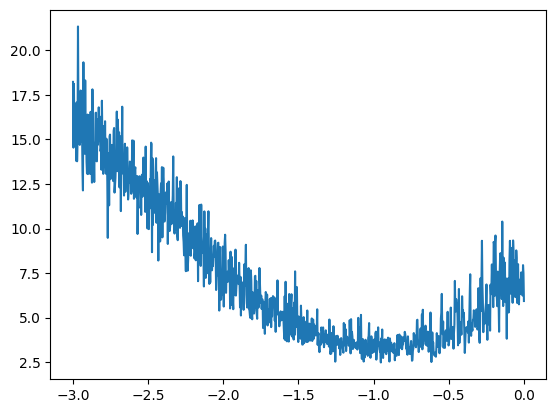

In [195]:
plt.plot(lri,lossi)

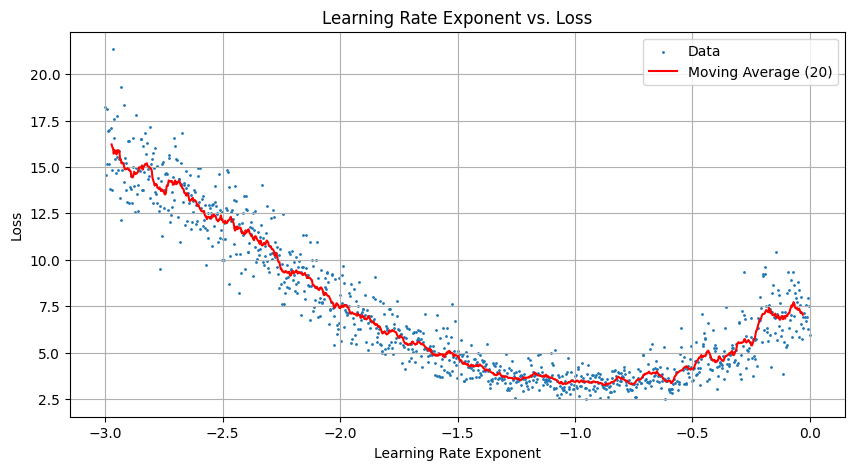

In [196]:
# Making the graph a bit fancier

lri_tensor = torch.tensor(lri)
lossi_tensor = torch.tensor(lossi)

# Calculate the moving average
window_size = 20 # You can adjust this to your desired window size
moving_average = lossi_tensor.unfold(0, window_size, 1).mean(dim=1)

# Create a scatter plot of your data points
plt.figure(figsize=(10, 5))
plt.scatter(lri, lossi, label='Data', marker='o', s=1)

# Plot the moving average in red
x_values = lri[(window_size-1)//2 : -(window_size-1)//2]  # Adjust x values
plt.plot(x_values, moving_average, color='red', label=f'Moving Average ({window_size})')

plt.xlabel('Learning Rate Exponent')
plt.ylabel('Loss')
plt.title('Learning Rate Exponent vs. Loss')
plt.grid(True)
plt.legend()
plt.show()


Based on the graph, it seems like an initial $10^{-1}=0.1$ learning rate is at the bottom of the valley of the curve and is likely the learning rate we'd want to use.

After we set this learning rate and the loss seems to plateau, we can then use an order of magnitude smaller learning curve (e.g. 0.01) to get futher optimization. That is often called a ***learning curve decay***.

> Note: I still have an outstanding question / doubt about the approach to setting the learning rate. I [commented on the video](https://www.youtube.com/watch?v=TCH_1BHY58I&lc=UgyQzgsORSKB1Nq6KOR4AaABAg) about it. I didn't keep that code / graph where I shuffle the learning rates here in this notebook, but it is something I'd like to explore further at some point.

```
Andrej - I have a question about the approach you took to explore and optimize the learning rate. Since the loss is both a function of the gradient and the learning rate, wouldn't this graph be skewed based on earlier iterations through your loop when loss will be impacted more by the gradient than in later iterations when the gradient descent gets smaller? Just to experiment, I tried randomizing the lre list up front and then resorting it after all the training epochs have completed, and I get a very different (more uniform) graph of learning rate to loss. I'm curious what your thoughts are here.
```



## Training vs. Testing

Using this MLP approach, we now know that we can achieve a lower loss of around ~2.33 as opposed to the ~2.4 loss we achieved with the bigram model in the previous part of this exercise.

But, just because we can achieve a lower loss doesn't mean we have a better model. As the total number of parameters in our network grows, a lower loss could indicate that we're ***overfitting***, or starting to memorize our training set, verbatim.

To account for this, we can split our data into:
* **Training** 80% - Optimize the parameters
* **Dev/Validation** - 10% - Optimize the hyperparameters (hidden layer, regularization, etc)
* **Test** - 10% - Validate the performance of the model at the end

In [197]:
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("Dataset Shape: ", X.shape, Y.shape)

    return X, Y

In [198]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_dataset(words[  :n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte   = build_dataset(words[n2:])

Dataset Shape:  torch.Size([182437, 3]) torch.Size([182437])
Dataset Shape:  torch.Size([22781, 3]) torch.Size([22781])
Dataset Shape:  torch.Size([22928, 3]) torch.Size([22928])


## Decaying learning rate

Here we'll set up a learning rate that will start at 0.1 and will decay as we run more epochs.

We can try different fractions of the total epoch for the decay rate. Here we're showing what it might look like with 300K epochs and a decay factor of 3.

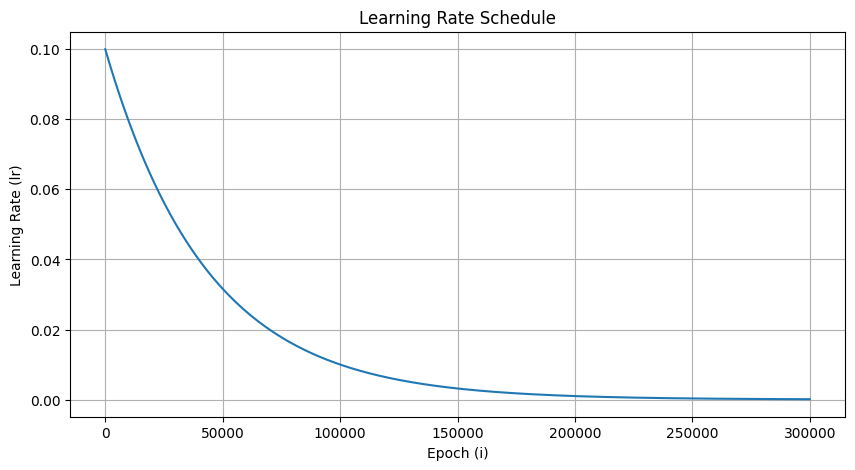

In [199]:
initial_lr = 0.1
epochs = 300000
decay_factor = 3
decay = epochs / decay_factor
i_values = range(0, 300000)  # Range from 1 to 300000
lr_values = [initial_lr * (0.1 ** (i / decay)) for i in i_values]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(i_values, lr_values)
plt.xlabel('Epoch (i)')
plt.ylabel('Learning Rate (lr)')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [200]:
def caluclate_learning_rate( total_epochs, current_epoch, initial_lr, decay_factor=3 ):
    decay = total_epochs / decay_factor
    return initial_lr * (initial_lr ** (current_epoch / decay))

## Visualizing the Character Embeddings

While we have a 2d feature vector space we can visualize the character embeddings.

Interesting notes
- Vowels are clustered
- q is pretty far away from everything
- . is pretty far away
- other letters are clustered
- w, x are clustered but apart from the main cluster

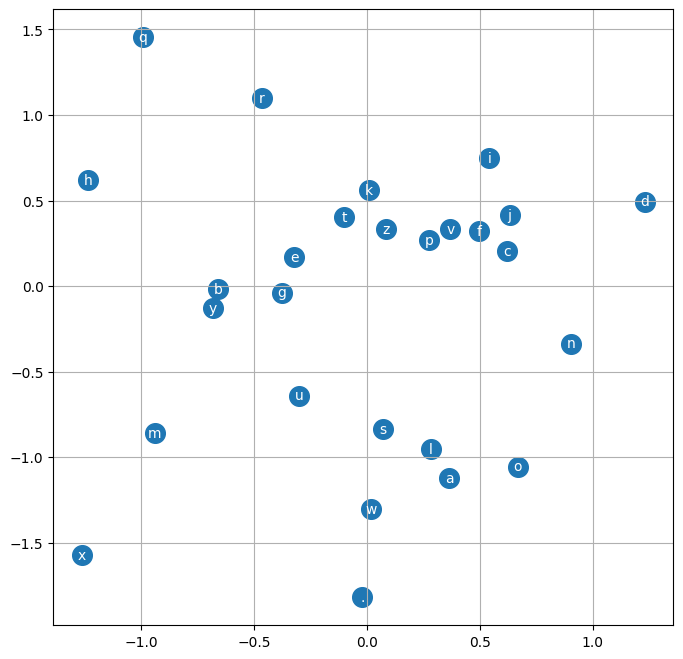

In [201]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

## Final test

In [213]:
# Hyperparameters
block_size=3
embedding_dimensions=20
epochs = 100000
initial_lr = 0.5
batch_size = 256
decay_factor = 1.25
hidden_layer = 200

In [214]:
# RESET THE MODEL
reset_model(hidden_layer=hidden_layer, embedding_dimensions=embedding_dimensions)

Model Parameters:  18167


In [215]:
# Training
lossi = []
stepi = []

print("Starting...")

for i in range(1, epochs + 1):
    # minibatch construct, only using Xtr since we're training
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, embedding_dimensions)
    h = torch.tanh( emb.view( -1, block_size * embedding_dimensions ) @ W1 + b1 ) # (batch_size, 100)
    logits = h @ W2 + b2 # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Ytr[ix])

    if i % 10000 == 0:
        print("Batch loss: ", loss.item()) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = caluclate_learning_rate( epochs, i, initial_lr, decay_factor=decay_factor )
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

print("Done...")

Starting...
Batch loss:  2.2080562114715576
Batch loss:  2.284038782119751
Batch loss:  2.1689066886901855
Batch loss:  2.0812644958496094
Batch loss:  2.334080934524536
Batch loss:  2.0478971004486084
Batch loss:  2.1097006797790527
Batch loss:  1.9479869604110718
Batch loss:  2.0249578952789307
Batch loss:  1.9667704105377197
Done...


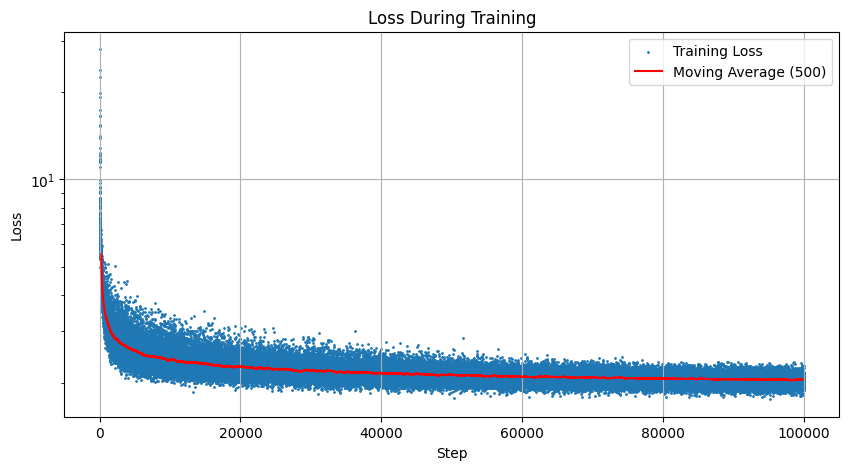

In [216]:
# plt.plot(stepi, lossi, label='Training Loss')

window_size = 500  # You can adjust this to your desired window size
lossi_tensor = torch.tensor(lossi, dtype=torch.float32)
moving_average = lossi_tensor.unfold(0, window_size, 1).mean(dim=1)

# Create a scatter plot of your data points
plt.figure(figsize=(10, 5))
plt.scatter(stepi, lossi, label='Training Loss', marker='o', s=1)

# Plot the moving average in red
x_values = stepi[(window_size-1)//2 : -(window_size-1)//2]  # Adjust x values
plt.plot(x_values, moving_average, color='red', label=f'Moving Average ({window_size})')


plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.grid(True)
plt.yscale('log')

plt.legend()
plt.show()

In [217]:
# Evaluate using the dev set Xdev, Ydev
def calculate_loss( X, Y ):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh( emb.view( -1, block_size * embedding_dimensions ) @ W1 + b1 ) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    full_loss = F.cross_entropy(logits, Y)
    return full_loss.item()

print("Training loss: ", calculate_loss( Xtr, Ytr ) )
print("Dev loss: ", calculate_loss( Xdev, Ydev ) )
print("Test loss: ", calculate_loss( Xte, Yte ) )


Training loss:  2.061422824859619
Dev loss:  2.1926729679107666
Test loss:  2.1795477867126465


## Optimization and Hyperparameter Tuning

If we split our dev and test set and see that our dev set is getting a fairly good loss, we can feel confident that we're not ***overfitting*** to the training data. 

But, if our dev loss and training loss are nearly equal, we may actually be ***underfitting***. That may mean our network is very tiny, so we can try to scale up the neural net until we see that they're starting to diverge a bit. 

Here are some levers I played around with for hyperparameter tuning:
```
epoch_range = [25000]
embedding_dimensions_range = [2, 6, 10, 20]
initial_lr_values = [0.5, 0.1, 0.05]
batch_size_values = [32, 64, 128, 256]
decay_factor_values = [3, 2, 1.5, 1.25]
hidden_layer_values = [100, 200, 300, 500]
block_size = [3, 4]
```


### Best loss with 25,000 epochs

The following table shows the best Dev Loss I could optimize just using 25000 epochs, and not doing any of the additional optimizations from the next video in the series.

| block_size | num_params | embedding_dimensions | hidden_layer | epochs | initial_lr | batch_size | decay_factor | Training Loss | Dev Loss | Test Loss |
|------------|------------|----------------------|--------------|--------|------------|------------|--------------|---------------|----------|-----------|
| 3          | 18167      | 20                   | 200          | 25000  | 0.5        | 256        | 2            | 2.0959        | 2.1698   | 2.1704    |
| 3          | 18167      | 20                   | 200          | 25000  | 0.5        | 256        | 3            | 2.0993        | 2.1716   | 2.1801    |
| 3          | 18167      | 20                   | 200          | 25000  | 0.5        | 256        | 1.25         | 2.0978        | 2.1736   | 2.1738    |

### Best loss with 100,000 epochs

The following table shows a sample of the Dev Loss I optimized using 100,000 epochs, and not doing any of the additional optimizations from the next video in the series. I only ran through about 50 scenarios and performed significantly better than with 25,000 epochs and these were the best 3. 

| block_size | num_params | embedding_dimensions | hidden_layer | epochs | initial_lr | batch_size | decay_factor | Training Loss | Dev Loss | Test Loss |
|------------|------------|----------------------|--------------|--------|------------|------------|--------------|---------------|----------|-----------|
|3|17697|10|300|100000|0.5|256|1.5|2.0422|2.1294|2.1337|
|4|32967|20|300|100000|0.5|256|2|1.9828|2.1446|2.1489|
|3|18167|20|200|100000|0.5|256|1.25|2.0357|2.1480|2.1400|
|4|32967|20|300|100000|0.1|256|1.25|2.0988|2.1507|2.1554|


## Sampling from the model



In [212]:
g = torch.Generator().manual_seed(2147843647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


can.
ana.
kamaovia.
kaira.
kyrstia.
eminiilana.
maheno.
olaan.
arilynn.
aan.
dyne.
tom.
zaan.
saryanniyas.
canaseus.
gon.
jaan.
ykynn.
maria.
xan.
